# **<span style="color:cornflowerblue">Causal inference methods using MIMIC-IV shortened dataset</span>**

#### In this notebook, we will review illustrative examples of causal inference:
 * #### Linear regression
 * #### Linear regression assumptions tests + Cook's distance
 * #### Generalized Linear Model
 * #### Matching
 * #### Propensity score matching (PSM) 
# **Causal inference**

#### Of course, this is only an illustrative examples, as variables as age have been deidentified.
#### First, let's imagine all these patients were admitted for the same condition. Then, we could ask this question:
### **<span style="color:tomato">Does heparin shortens the average length of stay?</span>** 
#### Heparin is an anticoagulant used to prevent or treat blood clots.
#### First, let's rerun the previous code to get the same dataset

In [5]:
import numpy as np
import pandas as pd
import csv
import os
import glob
import random
import matplotlib.pyplot as plt
import seaborn as sns
!pip3 install missingno
import missingno as msno

In [206]:
df1 = pd.read_csv('diagnoses_icd.csv.gz', compression='gzip')
df2 = pd.read_csv('d_icd_diagnoses.csv.gz', compression='gzip')
df3 = pd.read_csv('admissions.csv.gz', compression='gzip')
int = pd.merge(df1, df2, on=['icd_code', 'icd_version'], how='left')
int2 = pd.merge(int, df3, on=['subject_id', 'hadm_id'], how='left')
df6 = pd.read_csv('patients.csv.gz', compression='gzip')
df = pd.merge(int2, df6, on=['subject_id'], how='left')
df = df.drop(columns=['edregtime', 'edouttime'])
df['admitlen'] = (pd.to_datetime(df['dischtime']) - pd.to_datetime(df['admittime']))/ np.timedelta64(1, 'D')
df4 = pd.read_csv('pharmacy.csv.gz', compression='gzip')
df4['ttt'] = [1 if x == 'Heparin' else 0 for x in df4['medication']]
df['admittime'] = pd.to_datetime(df['admittime']) 
df = pd.merge(df, df4[['subject_id', 'hadm_id','ttt']], on=['subject_id', 'hadm_id'], how='left')
df['gender2'] = [1 if x == 'F' else 0 for x in df['gender']]
df = df.dropna(subset=['ttt'])
df = df.dropna(subset=['admittime'])
df.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title,admittime,dischtime,deathtime,admission_type,...,race,hospital_expire_flag,gender,anchor_age,anchor_year,anchor_year_group,dod,admitlen,ttt,gender2
0,10035185,22580999,3,4139,9,Other and unspecified angina pectoris,2120-05-12 12:53:00,2120-05-17 16:00:00,NaN,URGENT,...,WHITE,0,M,70,2120,2014 - 2016,NaN,5.129861,0.0,0
1,10035185,22580999,3,4139,9,Other and unspecified angina pectoris,2120-05-12 12:53:00,2120-05-17 16:00:00,NaN,URGENT,...,WHITE,0,M,70,2120,2014 - 2016,NaN,5.129861,0.0,0
2,10035185,22580999,3,4139,9,Other and unspecified angina pectoris,2120-05-12 12:53:00,2120-05-17 16:00:00,NaN,URGENT,...,WHITE,0,M,70,2120,2014 - 2016,NaN,5.129861,0.0,0
3,10035185,22580999,3,4139,9,Other and unspecified angina pectoris,2120-05-12 12:53:00,2120-05-17 16:00:00,NaN,URGENT,...,WHITE,0,M,70,2120,2014 - 2016,NaN,5.129861,0.0,0
4,10035185,22580999,3,4139,9,Other and unspecified angina pectoris,2120-05-12 12:53:00,2120-05-17 16:00:00,NaN,URGENT,...,WHITE,0,M,70,2120,2014 - 2016,NaN,5.129861,0.0,0


#### Let's have a first crude look at the data

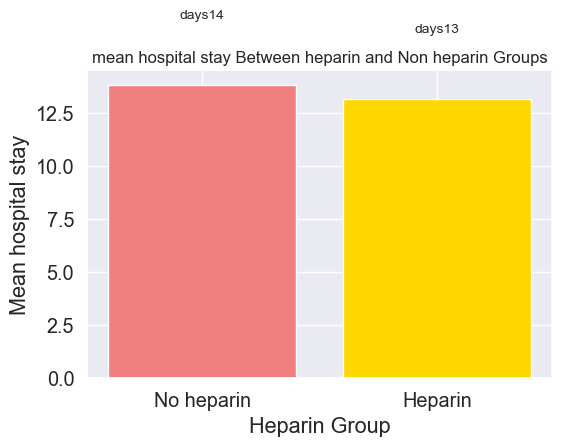

In [207]:
# Calculate mean hospital stay
mean_stay = df.groupby('ttt')['admitlen'].mean()

# Create bar plot
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(['No heparin', 'Heparin'], mean_stay, color=['lightcoral', 'gold'])

# Add labels and title
ax.set_title('mean hospital stay Between heparin and Non heparin Groups', fontsize=12)
ax.set_ylabel('Mean hospital stay')
ax.set_xlabel('Heparin Group')

# Annotate bar tops with dollar values
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, height + 3,
        f'days{height:,.0f}', ha='center', va='bottom', fontsize=10
    )

plt.show()

#### Interesting! We see the group treated with heparin has a shorter length of stay. But the length of stay can be short if the patient is discharged but also if the patient dies. 
#### We can have a quick look to the average of length of stay when people die or not. It seeems the length of stay is still longer on average in this dataset.

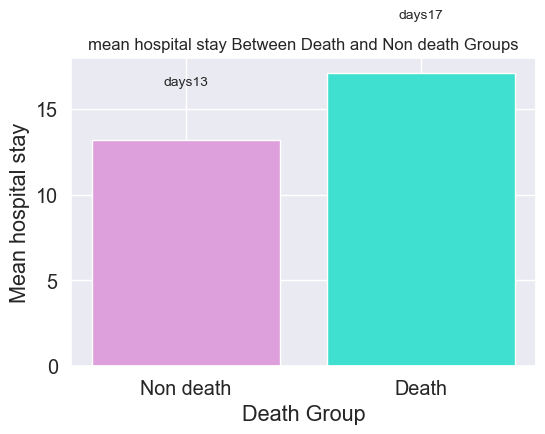

In [208]:
# Calculate mean hospital stay
mean_stay = df.groupby('hospital_expire_flag')['admitlen'].mean()

# Create bar plot
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(['Non death', 'Death'], mean_stay, color=['plum', 'turquoise'])

# Add labels and title
ax.set_title('mean hospital stay Between Death and Non death Groups', fontsize=12)
ax.set_ylabel('Mean hospital stay')
ax.set_xlabel('Death Group')

# Annotate bar tops with dollar values
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, height + 3,
        f'days{height:,.0f}', ha='center', va='bottom', fontsize=10
    )

plt.show()

#### Heparin could shorten the average length of stay by preventing thrombosis that delays recovery, but it could also prolong it through iatrogenic complications such as bleeding, hematomas, or the need for transfusion and monitoring. 

#### In the graphical causal model below we show the main counfounders (U for Unknown, Age and Gender, Comorbidity, Emergency admission as a partial proxy for severity. Maybe heparin as administered to people with less complications hence a shorter length of stay. The issue here is how to measure the effect of the treatment without accounting for the effect of counfounders?

 <img src=gracau.png width="35%" />

#### Theoratically, the best way to answer correctly this question would be to use **double blind randomization**: patients would randomly be assigned to either a treatment or a placebo group, and neither the participants nor the researchers would know who is receiving which. 
#### Double-blind randomization would eliminate confounding and treatment-selection bias entirely, but it is infeasible and would be judged unethical here because clinicians cannot be blinded or prevented from giving heparin when medically indicated. A randomized trial is prospective, controlling treatment assignment in advance.
#### Let's imagine nobody thought about that so we just get the data and we would still want to get some insight about it. 
#### We could try to use first **Linear regression** as it is fast and provides an adjusted association using all covariates at once, but it relies on correct model specification and linearity assumptions that may not hold in this clinical setting.
## **Linear regression**
#### First let's prepare the missing counfounder variables: Comorbidity and Emergency admission. 
#### For Emergency admission we can just have a binary variable if the admission as either "emergency" or "urgent".

In [209]:
df['emerg'] = [1 if x == 'EMERGENCY' or x == 'URGENT' else 0 for x in df['admission_type']]

<Axes: >

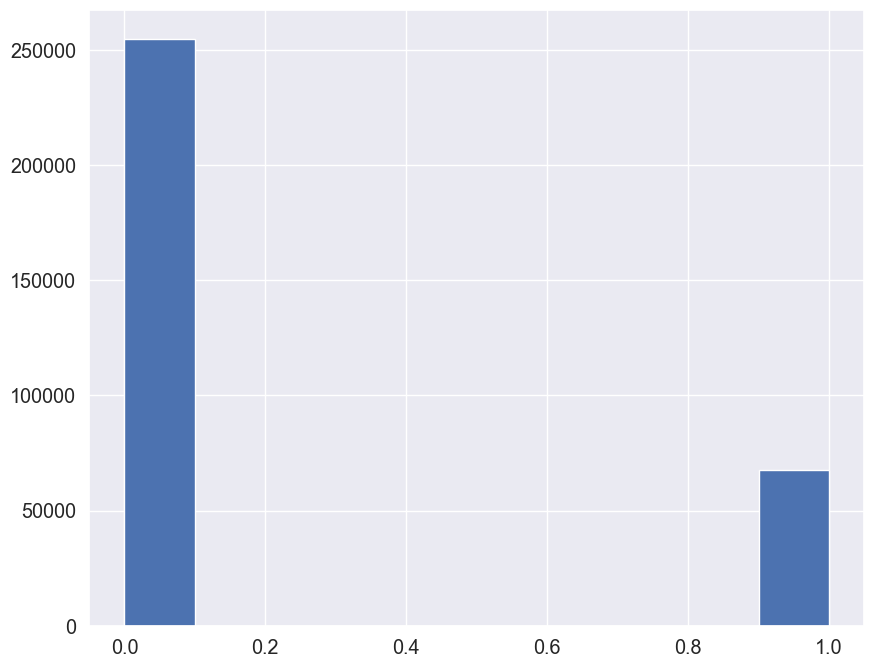

In [210]:
df['emerg'].hist()

#### For comorbidity, we can create a rough estimate of main comorbidities for each admission using a point system. For instance looking at diabetes, heart failure and kidney disease or failure:

In [211]:
df['long_title']=df['long_title'].str.lower()
res = df.groupby('hadm_id')['long_title'].apply(set).apply(list).to_frame()
res['long_title']=res['long_title'].apply(lambda x: ','.join(map(str, x)) if isinstance(x, list) else x)
# res['long_title']=res['long_title'].str.lower()
res
res['diab']=[1 if x.find('diabetes') != -1  else 0 for x in res['long_title']]
res['hf']=[1 if x.find('heart failure') != -1  else 0 for x in res['long_title']]
res['rf']=[1 if x.find('renal failure') != -1 or x.find('kidney failure') != -1 or x.find('chronic kidney diseas') != -1 else 0 for x in res['long_title']]
res['comoscore']=res['diab']+res['hf']+res['rf']
res=res.reset_index()
df = pd.merge(df, res[['hadm_id','comoscore']], on=['hadm_id'], how='left')

<Axes: >

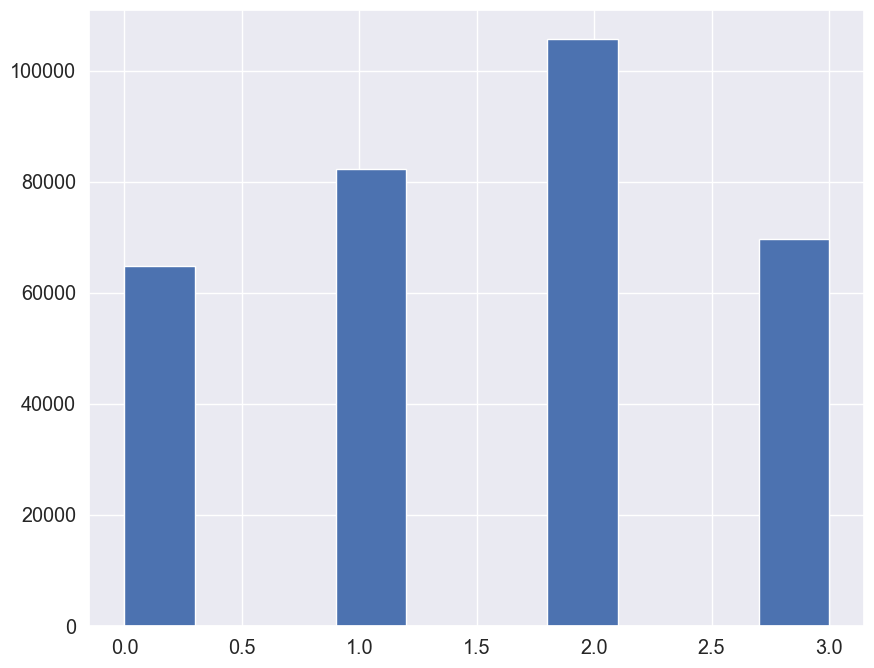

In [212]:
df['comoscore'].hist()

#### Let's have a first look at our regression results below. 

In [213]:
from statsmodels.formula.api import ols
reg = ols('admitlen ~ ttt + anchor_age + gender2 + emerg + comoscore', data=df)
rez = reg.fit()

print(rez.summary())

                            OLS Regression Results                            
Dep. Variable:               admitlen   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     4468.
Date:                Mon, 24 Nov 2025   Prob (F-statistic):               0.00
Time:                        23:52:32   Log-Likelihood:            -1.1818e+06
No. Observations:              322343   AIC:                         2.364e+06
Df Residuals:                  322337   BIC:                         2.364e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.1361      0.081    225.134      0.0

#### The linear regression shows a negative coefficient (-.2280) with a p<5. 
#### It could be interpreted as: after adjusting for age, gender, emergency status, and comorbidity, patients who received heparin had an average hospital stay that was 0.228 days (about 5.5 hours) shorter than similar patients who did not receive heparin. 
#### But let's first review the linear regression assumptions.

### **Linearity**
#### We check if the relationship between predictors and outcome is roughly linear and additive. We see it is not always the case in the CPR plots below, especially with age. As a reminder, age does not show true values in this dataset.

C:\Users\drgui\anaconda3\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


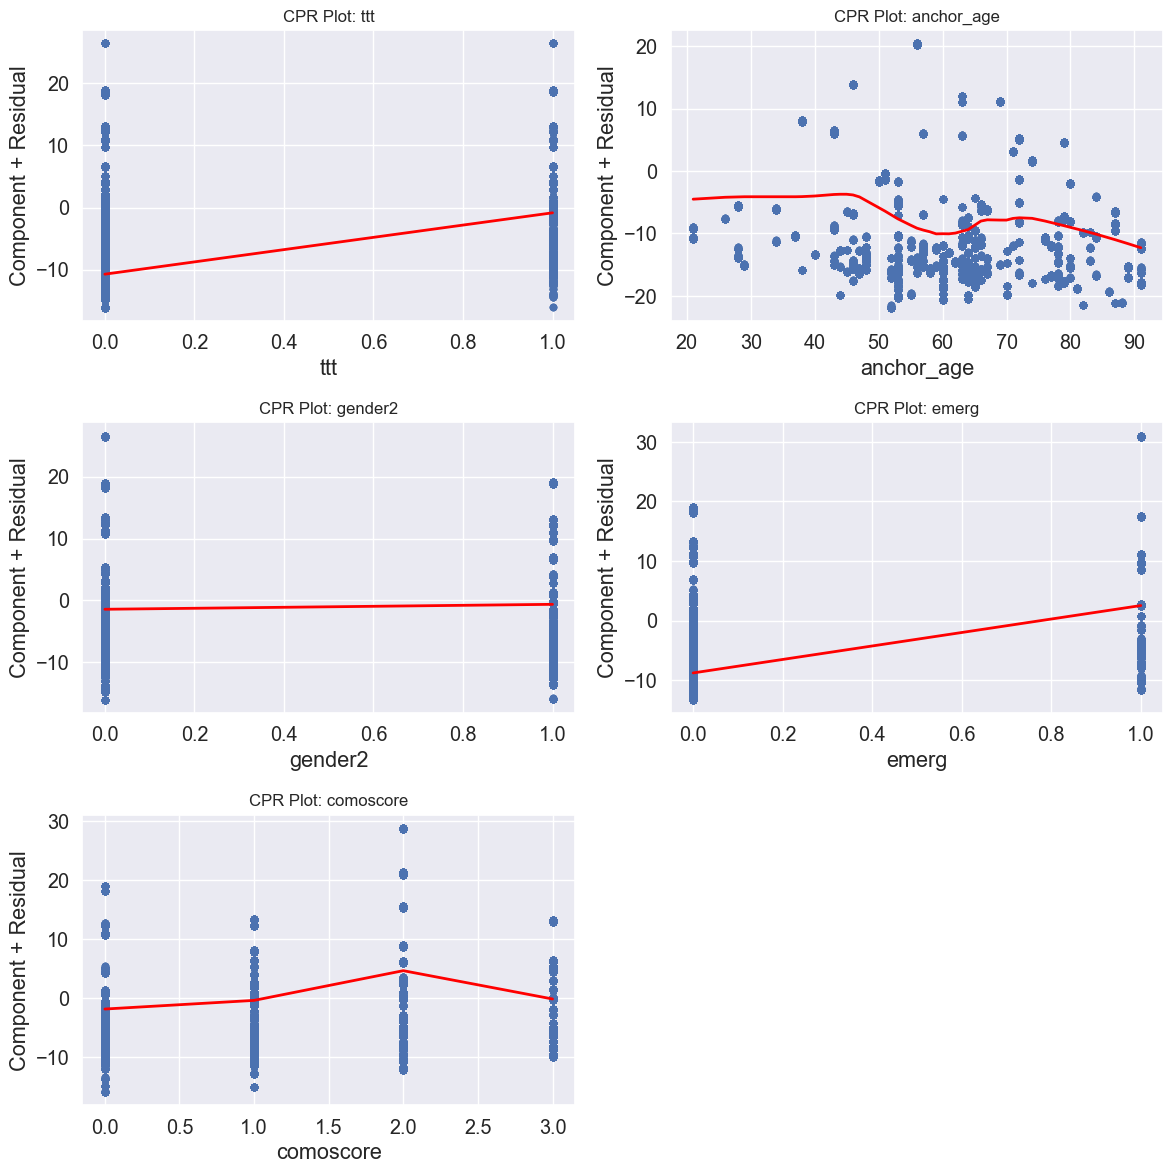

In [214]:
# 2. Extract residuals and coefficients
resid = rez.resid
params = rez.params

# 3. Define predictors for CPR plots
predictors = ["ttt", "anchor_age", "gender2", "emerg", "comoscore"]

# 4. Prepare CPR values for each predictor
cpr_data = {}

for p in predictors:
    # partial residual for predictor p
    partial_resid = resid + params[p] * df[p]
    cpr_data[p] = partial_resid

# 5. Plot multiple CPR graphs in one figure
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
axes = axes.flatten()

for i, p in enumerate(predictors):
    ax = axes[i]
    ax.scatter(df[p], cpr_data[p], alpha=0.5, s=20)
    
    # Add a smooth LOWESS line (optional, recommended)
    lowess = sm.nonparametric.lowess
    smoothed = lowess(cpr_data[p], df[p])
    ax.plot(smoothed[:, 0], smoothed[:, 1], color='red', linewidth=2)

    ax.set_title(f"CPR Plot: {p}", fontsize=12)
    ax.set_xlabel(p)
    ax.set_ylabel("Component + Residual")

# Hide last empty subplot if needed
if len(predictors) < len(axes):
    axes[-1].axis("off")

plt.tight_layout()
plt.show()

### **Homoscedasticity**
#### Linear regression assumes that the residuals are identically distributed. 
#### In the residual vs fitted graph, we see the points do not randomly on both sides of 0, but concentrate on the lower half, with some kind of funnel pattern.This indicates a potential violations of model assumptions. 
#### In the scale-location plot, the red line has a discernible upward trend that indicates heteroscedasticity, meaning the variance of the residuals is not constant and the model assumption is violated.
#### Finally the Breusch–Pagan Test confirms the Heteroscedasticity with high LM and F statistics and low p values.

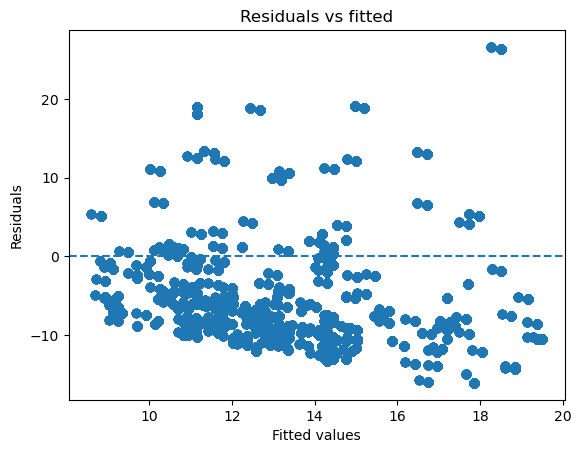

<F test: F=140.44970000908683, p=2.155820520423805e-32, df_denom=3.22e+05, df_num=1>


In [124]:
from statsmodels.stats.diagnostic import linear_reset

# 1a. Residuals vs fitted plot
fitted = rez.fittedvalues
resid  = rez.resid

plt.figure()
plt.scatter(fitted, resid)
plt.axhline(0, linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs fitted")
plt.show()

# 1b. Ramsey RESET test for functional form
reset_res = linear_reset(rez, power=2, use_f=True)
print(reset_res)

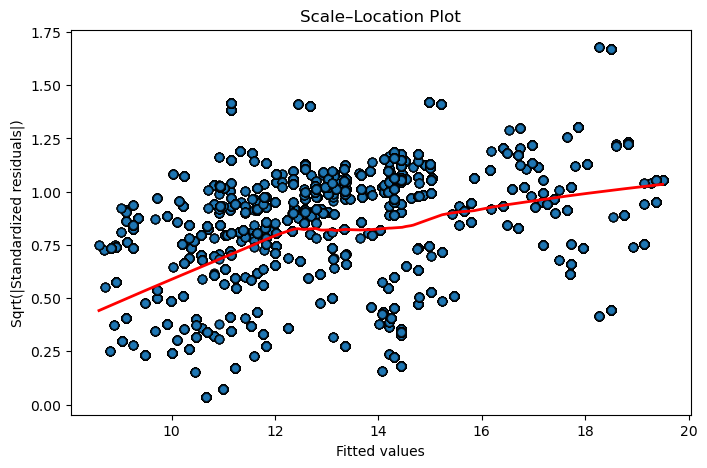

In [112]:
from statsmodels.nonparametric.smoothers_lowess import lowess

# Residuals and fitted values
fitted = rez.fittedvalues
resid = rez.resid

# Standardized residuals
stand_resid = resid / np.std(resid)

# Square root of absolute standardized residuals
sqrt_resid = np.sqrt(np.abs(stand_resid))

# LOWESS smoothing line
smooth = lowess(sqrt_resid, fitted, frac=0.6)

# Plot
plt.figure(figsize=(8,5))
plt.scatter(fitted, sqrt_resid, alpha=0.6, edgecolor="k")
plt.plot(smooth[:,0], smooth[:,1], color="red", linewidth=2)

plt.xlabel("Fitted values")
plt.ylabel("Sqrt(|Standardized residuals|)")
plt.title("Scale–Location Plot")
plt.show()

In [120]:

sm.qqplot(res.resid, line="45")
plt.title("Q–Q Plot of Regression Residuals")
plt.show()

LM Statistic: 29120.44374867725
LM p-value: 0.0
F Statistic: 6402.369992690518
F p-value: 0.0


### **Normality**
#### Linear regresion assumes the residuals are normally distributed. We see here a very strong left ske that seems to violate this assumption.

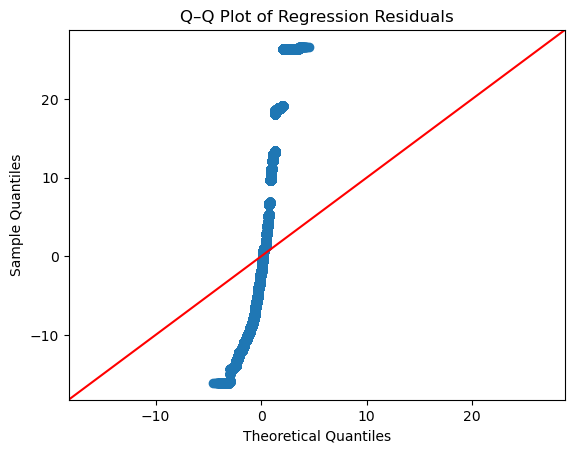

In [122]:
sm.qqplot(rez.resid, line="45")
plt.title("Q–Q Plot of Regression Residuals")
plt.show()

### **Independance**
#### To check for independence, we can revie the variance inflation factor (VIF) that quantifies how much the variance is inflated: the standard errors  and hence the variances of the estimated coefficients are inflated when multicollinearity exists. A variance inflation factor exists for each of the predictors in a multiple regression model. The general rule of thumb is that VIFs exceeding 4 warrant further investigation, while VIFs exceeding 10 are signs of serious multicollinearity requiring correction. 
#### Here the VIF look quite good.

In [138]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select predictors only
X = df[['ttt', 'anchor_age', 'gender2', 'emerg', 'comoscore']]

# Remove rows with NaN or infinite values
X = X.replace([np.inf, -np.inf], np.nan).dropna()

# Add constant term
X_const = sm.add_constant(X)

# Compute VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X_const.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_const.values, i)
    for i in range(X_const.shape[1])
]

print(vif_data)

     Variable        VIF
0       const  23.358733
1         ttt   1.001539
2  anchor_age   1.087357
3     gender2   1.004364
4       emerg   1.009779
5   comoscore   1.097630


#### Finally, **Cook’s Distance** measures how much each observation influences the regression coefficients. Here we see some very influential observations in the graph which are gathered as large bars in the graph below. For a real dataset, it would be important to review these observations as a knowledge expert to ensure the data is valid and not some kind of error.

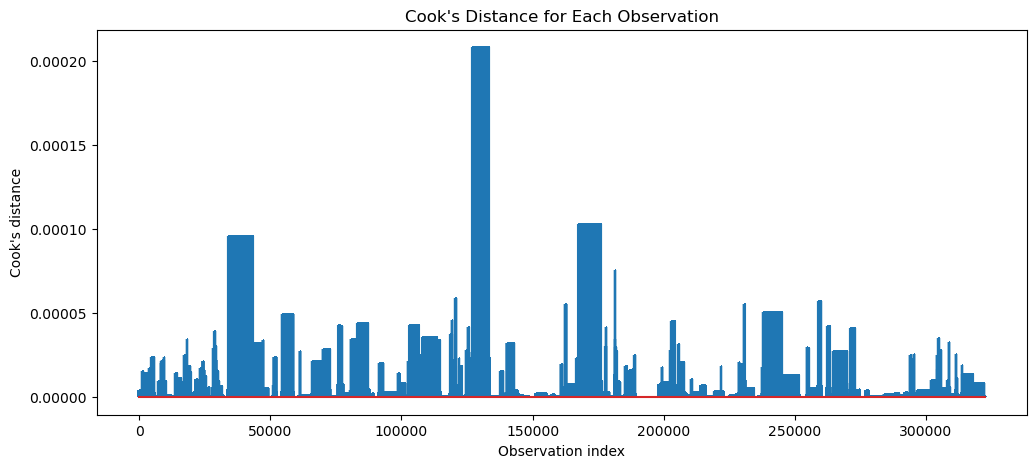

Influential observations (Cook’s D > 4/n): 10536 points


In [147]:
# Influence measures
influence = rez.get_influence()

# Cook’s distance values
cooks_d = influence.cooks_distance[0]

# Plot Cook’s Distance
plt.figure(figsize=(12,5))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")   
plt.xlabel("Observation index")
plt.ylabel("Cook's distance")
plt.title("Cook's Distance for Each Observation")
plt.show()

# Optional: Flag influential observations
influential_points = np.where(cooks_d > 4/len(cooks_d))[0]
print("Influential observations (Cook’s D > 4/n):", len(influential_points),'points')

#### Overall, linear regression is not an ideal model in our case, as assumptions of linearity, Homoscedasticity and normality are violated. 
#### An interesting alternative is to use a **GLM = generalized linear model** as you can choose your error distribution (here we pick a gamma distribution as the length of stay is positive) ith a log link function (Poisson distribution). GLM accomodates heteroscedasticity.    

In [215]:
import statsmodels.formula.api as smf

gamma_model = smf.glm(
    formula='admitlen ~ ttt + anchor_age + gender2 + emerg + comoscore',
    data=df,
    family=sm.families.Gamma(sm.families.links.Log())
)

gamma_res = gamma_model.fit()
print(gamma_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               admitlen   No. Observations:               322343
Model:                            GLM   Df Residuals:                   322337
Model Family:                   Gamma   Df Model:                            5
Link Function:                    Log   Scale:                         0.44712
Method:                          IRLS   Log-Likelihood:            -1.1228e+06
Date:                Mon, 24 Nov 2025   Deviance:                   1.6648e+05
Time:                        23:53:03   Pearson chi2:                 1.44e+05
No. Iterations:                    19   Pseudo R-squ. (CS):            0.06949
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9715      0.006    522.035      0.0

## **Matching**
#### So researchers may consider Matching. 
#### Matching compares treated and untreated patients with similar covariates without assuming any functional form, while linear regression estimates an average adjusted effect under strong linearity assumptions, and GLM relaxes those assumptions by modeling the outcome distribution but still depends on correctly specifying the link function and covariate structure.
#### Matching creates treated and untreated groups with similar clinical profiles without assuming linear relationships, but it can perform poorly when good matches are scarce or important confounders are unobserved. Compared to randomized prospective data collection, matching is a retrospective method that tries to reconstruct comparability after the data have already been collected.

In [216]:
from sklearn.neighbors import NearestNeighbors

# Keep only needed variables
match_df = df[['admitlen', 'ttt', 'anchor_age', 'gender2', 'emerg', 'comoscore']].dropna()

# Split treated and control
treated = match_df[match_df['ttt'] == 1].copy()
control = match_df[match_df['ttt'] == 0].copy()

# Covariates used for matching
X_treated = treated[['anchor_age', 'gender2', 'emerg', 'comoscore']].values
X_control = control[['anchor_age', 'gender2', 'emerg', 'comoscore']].values

# Fit nearest neighbor model
nn = NearestNeighbors(n_neighbors=1)
nn.fit(X_control)

# For each treated unit, find closest control
distances, indices = nn.kneighbors(X_treated)

# Extract matched controls
matched_controls = control.iloc[indices.flatten()].copy()
matched_treated = treated.reset_index(drop=True)

# Compute individual treatment effects
matched_treated['control_admitlen'] = matched_controls['admitlen'].values
matched_treated['effect'] = matched_treated['admitlen'] - matched_treated['control_admitlen']

# ATT (average treatment effect on treated)
ATT = matched_treated['effect'].mean()

print("Average Treatment Effect on the Treated (matching):", ATT)

Average Treatment Effect on the Treated (matching): 1.042327599566093


In [230]:
# Build matched dataframe (treated + matched control)
matched_df = matched_treated.copy()
matched_df['ttt'] = 1
matched_df = matched_df.reset_index(drop=True)

matched_controls = matched_controls.copy()
matched_controls['ttt'] = 0
matched_controls = matched_controls.rename(columns={'control_admitlen': 'admitlen'})
matched_controls = matched_controls.reset_index(drop=True)
# matched_controls = matched_controls.rename(columns={'admitlen': 'control_admitlen'})

# Put treated and control back together
reg_df = pd.concat(    [matched_df[['admitlen','ttt','anchor_age','gender2','emerg','comoscore']],
    matched_controls[['admitlen','ttt','anchor_age','gender2','emerg','comoscore']]]
,axis=0)

# # rename variables so controls have analogous names
# reg_df['ttt'] = reg_df['treated']
# reg_df['admitlen'] = reg_df['control_admitlen'].fillna(reg_df['admitlen'])

reg = ols('admitlen ~ ttt + anchor_age + gender2 + comoscore + emerg', data=reg_df)
rem = reg.fit()

print(rem.summary())

                            OLS Regression Results                            
Dep. Variable:               admitlen   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     1186.
Date:                Tue, 25 Nov 2025   Prob (F-statistic):               0.00
Time:                        00:00:29   Log-Likelihood:                -51166.
No. Observations:               14340   AIC:                         1.023e+05
Df Residuals:                   14334   BIC:                         1.024e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.8558      0.330     60.156      0.0

#### Here we find an average treatment effect on the treated (ATT) of 1.04 with a very small p which means that heparin patients had actually longer stays by 1 day than similar non-heparin patients! 
#### Did the matching perform poorly because of selection bias, as the people who received heparing were not similar to those who didnt? 
#### Let's see if Propensity Score Matching gives a different estimate.

## **Propensity score matching (PSM)** 
#### Propensity score matching (PSM) is a statistical method used in observational studies to reduce selection bias by creating comparable treatment and control groups. Propensity score matching (PSM) allows us to construct an artificial control group based on the similarity of the treated and non-treated individuals. It works by first estimating the likelihood (propensity score) of each individual receiving a treatment based on their observable characteristics. Then, individuals with similar propensity scores are matched, and the difference in outcomes between the matched groups is used to estimate the treatment effect.

In [156]:
#We first remove rows with nan in our two main columns

dfps= df.dropna(subset=['ttt', 'admitlen'])

#### To check if the groups in the experiment are comparable we inspect the distribution of the pre-treatment variables across both groups. If they differ, it concludes that both groups are different, and we have to dig deeper to explore any causal relationship.<br>A density plot visualizes the distribution of a continuous variable using a smooth, continuous curve, which is a smoothed-out version of a histogram. It shows the shape of the data, the central tendency, and the spread, with the total area under the curve equaling 1. By overlaying multiple curves, density plots are also effective for comparing the distributions of different groups

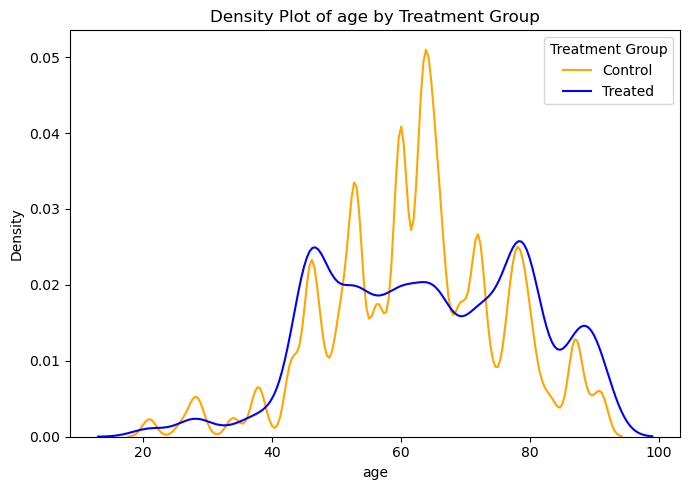

In [157]:
# Create density plot for age by treatment group
plt.figure(figsize=(7, 5))
sns.kdeplot(data=dfps[dfps['ttt'] == 0]['anchor_age'], label='Control', color='orange')
sns.kdeplot(data=dfps[dfps['ttt'] == 1]['anchor_age'], label='Treated', color='blue')

# Labels and title
plt.title('Density Plot of age by Treatment Group')
plt.xlabel('age')
plt.ylabel('Density')
plt.legend(title='Treatment Group')

plt.tight_layout()
plt.show()

In [159]:
from scipy import stats

# Separate groups
treated = dfps[dfps['ttt'] == 1]['anchor_age']
control = dfps[dfps['ttt'] == 0]['anchor_age']

# Compare means
print("Average age (Treated):", treated.mean())
print("Average age (Control):", control.mean())

# Independent samples t-test
t_stat, p_value = stats.ttest_ind(treated, control, equal_var=False)

print("\nT-statistic:", t_stat)
print("P-value:", p_value)

Average age (Treated): 1.4513249651324964
Average age (Control): 1.5611108819600663

T-statistic: -8.81026061832571
P-value: 1.5321388874420885e-18


#### Age distribution and average are not similar across the treated and control groups, observation confirmed by the t-test and the tiny p value.
#### If we look at our comorbidity score as a continuous variable, results are similar.

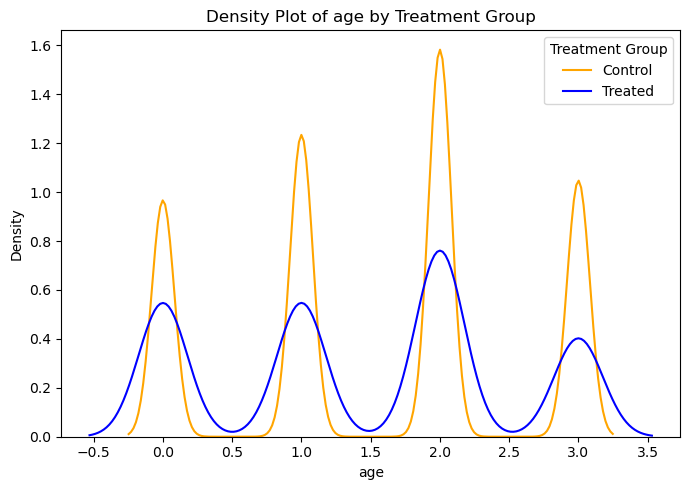

In [160]:
# Create density plot for age by treatment group
plt.figure(figsize=(7, 5))
sns.kdeplot(data=dfps[dfps['ttt'] == 0]['comoscore'], label='Control', color='orange')
sns.kdeplot(data=dfps[dfps['ttt'] == 1]['comoscore'], label='Treated', color='blue')

# Labels and title
plt.title('Density Plot of age by Treatment Group')
plt.xlabel('age')
plt.ylabel('Density')
plt.legend(title='Treatment Group')

plt.tight_layout()
plt.show()

In [161]:
# Separate groups
treated = dfps[dfps['ttt'] == 1]['comoscore']
control = dfps[dfps['ttt'] == 0]['comoscore']

# Compare means
print("Average age (Treated):", treated.mean())
print("Average age (Control):", control.mean())

# Independent samples t-test
t_stat, p_value = stats.ttest_ind(treated, control, equal_var=False)

print("\nT-statistic:", t_stat)
print("P-value:", p_value)

Average age (Treated): 1.4513249651324964
Average age (Control): 1.5611108819600663

T-statistic: -8.81026061832571
P-value: 1.5321388874420885e-18


#### We can look at the binary variables and see the treatment group is not comparable to the non-treated.

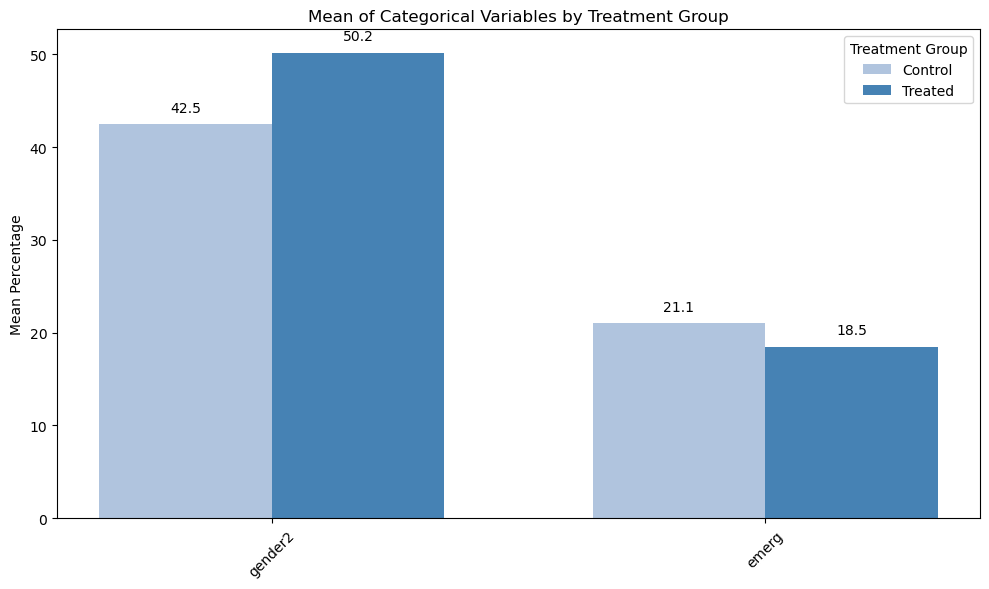

In [164]:
# Select categorical variables to compare
categorical_vars = ['gender2', 'emerg']

# Compute group means
means = dfps.groupby('ttt')[categorical_vars].mean().T * 100
means.columns = ['Control', 'Treated']

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
x = range(len(means))

bars1 = ax.bar([p - bar_width/2 for p in x], means['Control'], bar_width, label='Control', color='lightsteelblue')
bars2 = ax.bar([p + bar_width/2 for p in x], means['Treated'], bar_width, label='Treated', color='steelblue')

# Add labels
ax.set_xticks(x)
ax.set_xticklabels(means.index, rotation=45)
ax.set_ylabel('Mean Percentage')
ax.set_title('Mean of Categorical Variables by Treatment Group')
ax.legend(title='Treatment Group')

# Add percentage labels above bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.1f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [165]:
from statsmodels.stats.proportion import proportions_ztest

treated = df[df['ttt'] == 1]
control = df[df['ttt'] == 0]

def perform_ztest(count1, nobs1, count2, nobs2):
    z_stat, p_val = proportions_ztest([count1, count2], [nobs1, nobs2])
    return z_stat, p_val

binary_vars = ['gender2', 'emerg']

ztest_results = []
for var in binary_vars:
    count_treated = treated[var].sum()
    count_control = control[var].sum()
    nobs_treated = treated[var].count()
    nobs_control = control[var].count()
    z_stat, p_val = perform_ztest(count_treated, nobs_treated, count_control, nobs_control)
    ztest_results.append({'Variable': var, 'Z-Statistic': round(z_stat, 2), 'P-Value': f"{p_val:.3f}"})

ztest_results = pd.DataFrame(ztest_results)

ztest_results

,Variable,Z-Statistic,P-Value
0,gender2,13.01,0.000
1,emerg,-5.26,0.000


#### We will then estimate the likelihood of the treatment that will allow us to compute the propensity score for each hospitalization.

In [170]:
from sklearn.linear_model import LogisticRegression

pre_treatment_vars = ['anchor_age', 'gender2', 'emerg', 'comoscore']

X = dfps[pre_treatment_vars]
y = dfps['ttt']


log_reg = LogisticRegression()
log_reg.fit(X, y)
dfps['propensity_score_logistic'] = log_reg.predict_proba(X)[:, 1]

C:\Users\drgui\AppData\Local\Temp\ipykernel_29548\2819465824.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfps['propensity_score_logistic'] = log_reg.predict_proba(X)[:, 1]


,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title,admittime,dischtime,deathtime,admission_type,...,anchor_age,anchor_year,anchor_year_group,dod,admitlen,ttt,gender2,emerg,comoscore,propensity_score_logistic
0,10035185,22580999,3,4139,9,other and unspecified angina pectoris,2120-05-12 12:53:00,2120-05-17 16:00:00,NaN,URGENT,...,70,2120,2014 - 2016,NaN,5.129861,0.0,0,1,1,0.020406
1,10035185,22580999,3,4139,9,other and unspecified angina pectoris,2120-05-12 12:53:00,2120-05-17 16:00:00,NaN,URGENT,...,70,2120,2014 - 2016,NaN,5.129861,0.0,0,1,1,0.020406
2,10035185,22580999,3,4139,9,other and unspecified angina pectoris,2120-05-12 12:53:00,2120-05-17 16:00:00,NaN,URGENT,...,70,2120,2014 - 2016,NaN,5.129861,0.0,0,1,1,0.020406
3,10035185,22580999,3,4139,9,other and unspecified angina pectoris,2120-05-12 12:53:00,2120-05-17 16:00:00,NaN,URGENT,...,70,2120,2014 - 2016,NaN,5.129861,0.0,0,1,1,0.020406
4,10035185,22580999,3,4139,9,other and unspecified angina pectoris,2120-05-12 12:53:00,2120-05-17 16:00:00,NaN,URGENT,...,70,2120,2014 - 2016,NaN,5.129861,0.0,0,1,1,0.020406


#### The chart below shows that control group observations are much more numerous than the treated observations. 

#### we also spot at the base the existence of the overlapping bars. Some units have a relatively high probability of being treated despite being assigned to the control group and some units in the treated groups are less likely to be treated. It enables us to find similar individuals in both groups, which is crucial for calculating the treatment effect.

#### Given that the propensity score indicates the probability of being treated, individuals with similar propensity scores are likely to exhibit similar characteristics. When we identify a treated individual and someone similar but originally in the control group, the difference between them could only be attributed to the treatment. The disparity in the outcome variable between such units will indicate the treatment effect.

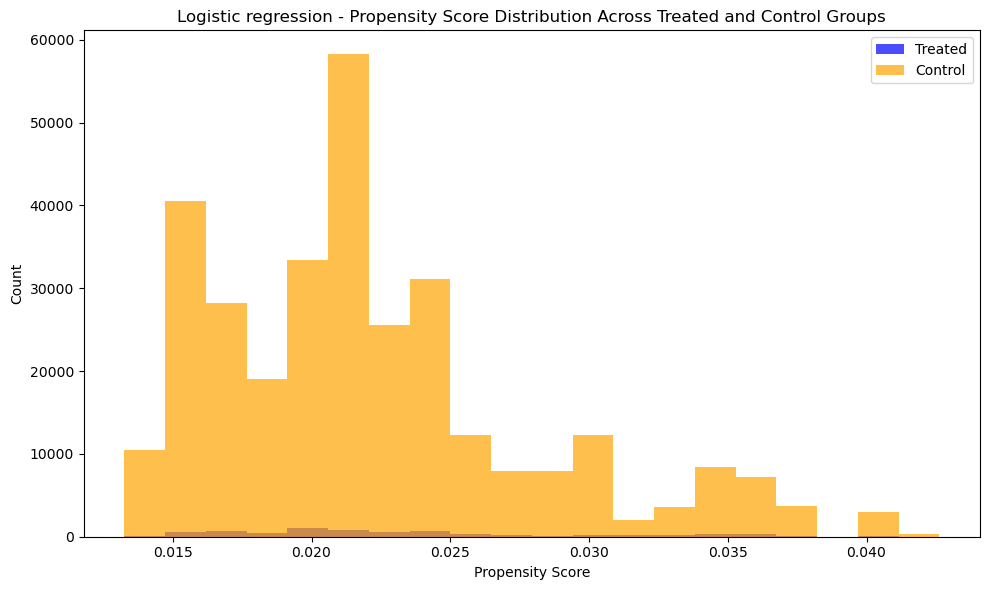

In [171]:
# Plot propensity score distributions
plt.figure(figsize=(10, 6))
plt.hist(
    dfps[dfps['ttt'] == 1]['propensity_score_logistic'],
    bins=20, alpha=0.7, color='blue', label='Treated'
)
plt.hist(
    dfps[dfps['ttt'] == 0]['propensity_score_logistic'],
    bins=20, alpha=0.7, color='orange', label='Control'
)

plt.title('Logistic regression - Propensity Score Distribution Across Treated and Control Groups')
plt.xlabel('Propensity Score')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

#### This version of propensity score matching trims down the control group only to units similar to the ones in the treatment group. It is one of the drawbacks of the propensity score matching, as we will end up with a smaller (but more accurate) data set.

#### Propensity score matching allows us to calculate the average treatment effect on treatment (ATT) contrary to the average treatment effect (ATE).

* #### ATE refers to the entire population of interest; it measures the impact of the treatment in both the treatment and control groups. We can consider it the treatment effect if everyone in a given population received a treatment.

* #### ATT measures the impact of the treatment, but only on individuals who received the treatment. We match similar units from the control to the treated group.

## Nearest neighbors (NN) algorithm.

#### To conduct the matching step, we create 2 data frames, one for units from the treatment group and another for the control group. 

#### Then, we can initiate the NN algorithm, setting the n parameter to 1 as we seek the most precise match for each unit in the treatment group.

#### The ‘n’ parameter in the NN algorithm represents the number of nearest neighbors to consider. By setting it to 1, we ensure that each unit in the treatment group is matched with its closest counterpart in the control group.

#### Then, we apply the model to the control group to teach the model of the structure of the propensity scores in the control group.

#### Afterward, we apply the kNeighbors method of the fitted model to treatment groups. This step enables us to find units from the control group that are the most similar to the treatment group. We store the results in two variables:

- #### Distances – indicating distance (or similarity) to the nearest neighbor
- #### Indices – location (data frame index) of the most similar unit in the control group

#### Subsequently, we create the new_control data frame based on the indices above. Our new control group contains only units selected as the most similar to the treatment groups based on the propensity score. The only step left is to join the original treatment group data with the newly matched control group. It will be the final data set used to evaluate the effect of the treatment.

In [172]:
from sklearn.neighbors import NearestNeighbors

treated = dfps[dfps['ttt'] == 1]
control = dfps[dfps['ttt'] == 0]

nn = NearestNeighbors(n_neighbors=1)

nn.fit(control[['propensity_score_logistic']])

distances, indices = nn.kneighbors(treated[['propensity_score_logistic']])

matched_control_indices = indices.flatten()
new_control = control.iloc[matched_control_indices]

matched_data = pd.concat([treated, new_control])
matched_data

,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title,admittime,dischtime,deathtime,admission_type,...,anchor_age,anchor_year,anchor_year_group,dod,admitlen,ttt,gender2,emerg,comoscore,propensity_score_logistic
1028,10009049,22995465,2,4829,9,"bacterial pneumonia, unspecified",2174-05-26 08:21:00,2174-05-31 14:15:00,NaN,EW EMER.,...,56,2174,2014 - 2016,NaN,5.245833,1.0,0,0,1,0.019273
1063,10009049,22995465,7,99592,9,severe sepsis,2174-05-26 08:21:00,2174-05-31 14:15:00,NaN,EW EMER.,...,56,2174,2014 - 2016,NaN,5.245833,1.0,0,0,1,0.019273
1098,10009049,22995465,13,2768,9,hypopotassemia,2174-05-26 08:21:00,2174-05-31 14:15:00,NaN,EW EMER.,...,56,2174,2014 - 2016,NaN,5.245833,1.0,0,0,1,0.019273
1133,10009049,22995465,1,0388,9,other specified septicemias,2174-05-26 08:21:00,2174-05-31 14:15:00,NaN,EW EMER.,...,56,2174,2014 - 2016,NaN,5.245833,1.0,0,0,1,0.019273
1168,10009049,22995465,11,78791,9,diarrhea,2174-05-26 08:21:00,2174-05-31 14:15:00,NaN,EW EMER.,...,56,2174,2014 - 2016,NaN,5.245833,1.0,0,0,1,0.019273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318120,10004733,27411876,7,5849,9,"acute kidney failure, unspecified",2174-12-04 11:28:00,2174-12-27 14:00:00,NaN,URGENT,...,51,2174,2014 - 2016,NaN,23.105556,0.0,0,1,1,0.016108
318120,10004733,27411876,7,5849,9,"acute kidney failure, unspecified",2174-12-04 11:28:00,2174-12-27 14:00:00,NaN,URGENT,...,51,2174,2014 - 2016,NaN,23.105556,0.0,0,1,1,0.016108
318120,10004733,27411876,7,5849,9,"acute kidney failure, unspecified",2174-12-04 11:28:00,2174-12-27 14:00:00,NaN,URGENT,...,51,2174,2014 - 2016,NaN,23.105556,0.0,0,1,1,0.016108
318120,10004733,27411876,7,5849,9,"acute kidney failure, unspecified",2174-12-04 11:28:00,2174-12-27 14:00:00,NaN,URGENT,...,51,2174,2014 - 2016,NaN,23.105556,0.0,0,1,1,0.016108


#### To compare the balance between variables we look at the standardized mean difference; in the Propensity Score Matching case, the lower it is, the better.

In [173]:
def standarized_mean_difference(data, covars):
    
    treated = data[data['ttt'] == 1]
    control = data[data['ttt'] == 0]
    
    smd = {}
    
    for var in covars:
        mean_treated = treated[var].mean()
        mean_control = control[var].mean()
        sd_treated = treated[var].std()
        sd_control = control[var].std()
        smd[var] = abs(mean_treated - mean_control) / np.sqrt((sd_treated**2 + sd_control**2) / 2)
        
    return smd


smd_before_matching = standarized_mean_difference(df, pre_treatment_vars)
smd_after_matching = standarized_mean_difference(matched_data, pre_treatment_vars)

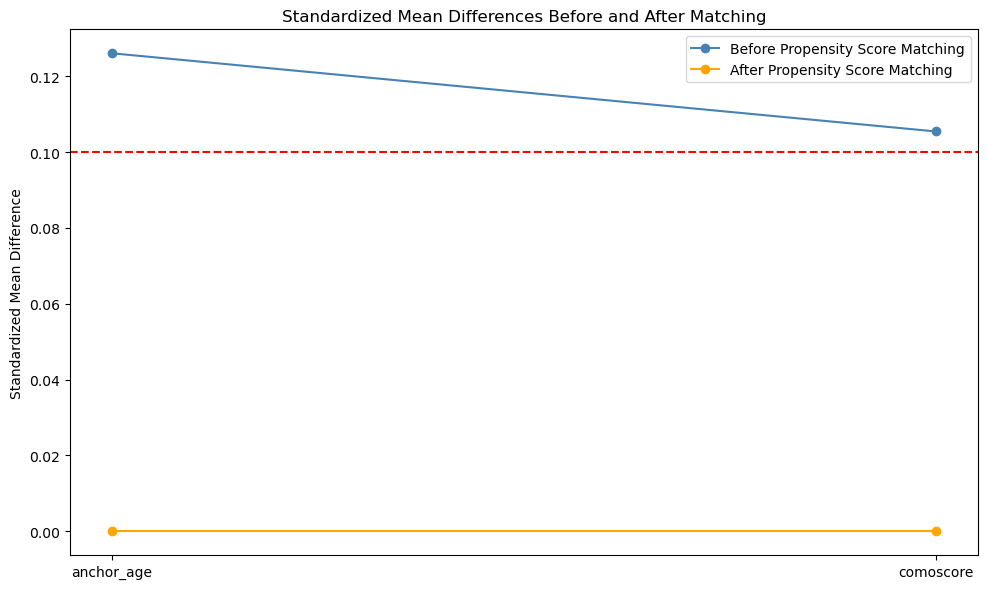

In [176]:
# If not already defined, pick the covariates to display in the plot
selected_vars = ['anchor_age', 'comoscore']  # matches the figure
# Prepare series for plotting
before_vals = [smd_before_matching[v] for v in selected_vars]
after_vals  = [smd_after_matching[v]  for v in selected_vars]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(selected_vars, before_vals, marker='o', label='Before Propensity Score Matching', color='steelblue')
plt.plot(selected_vars, after_vals,  marker='o', label='After Propensity Score Matching',  color='orange')
plt.axhline(0.1, color='red', linestyle='--')

plt.title('Standardized Mean Differences Before and After Matching')
plt.ylabel('Standardized Mean Difference')
plt.legend()
plt.tight_layout()
plt.show() 

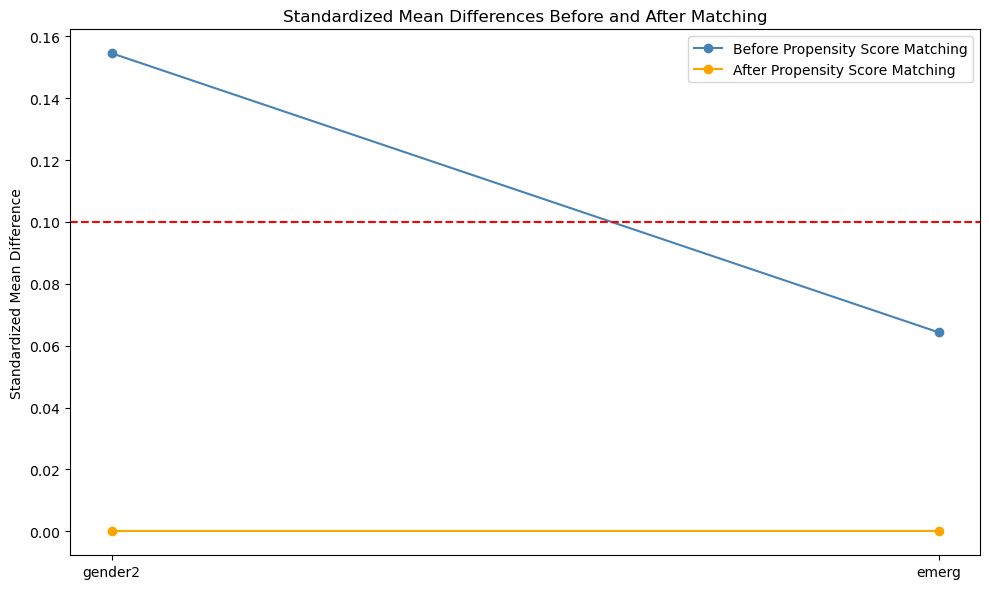

In [177]:
# If not already defined, pick the covariates to display in the plot
selected_vars = ['gender2', 'emerg']  # matches the figure
# Prepare series for plotting
before_vals = [smd_before_matching[v] for v in selected_vars]
after_vals  = [smd_after_matching[v]  for v in selected_vars]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(selected_vars, before_vals, marker='o', label='Before Propensity Score Matching', color='steelblue')
plt.plot(selected_vars, after_vals,  marker='o', label='After Propensity Score Matching',  color='orange')
plt.axhline(0.1, color='red', linestyle='--')

plt.title('Standardized Mean Differences Before and After Matching')
plt.ylabel('Standardized Mean Difference')
plt.legend()
plt.tight_layout()
plt.show() 

####  The balance after matching significantly improved compared to the initial lack of similarity between groups. The chart demonstrates that matching has notably enhanced the balance of most covariates. With most of them hovering below the 0.1 threshold, it’s evident that the control group, formed after applying the propensity score matching, is much more akin to the treatment group.

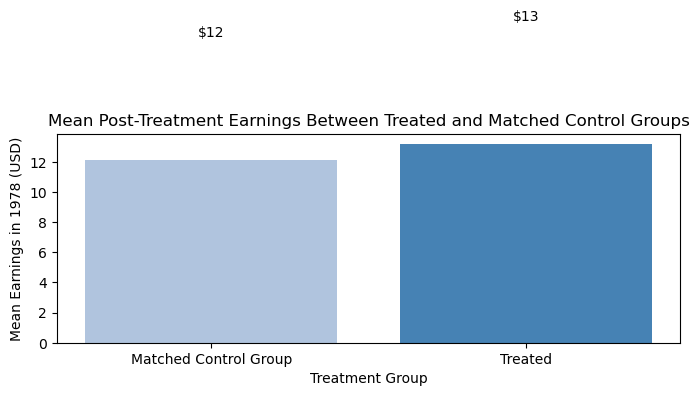

In [182]:
# Assuming matched_data, treated, and control groups are already created
# Calculate mean post-treatment earnings
treated_mean = matched_data[matched_data['ttt'] == 1]['admitlen'].mean()
matched_control_mean =  matched_data[matched_data['ttt'] == 0]['admitlen'].mean()

# Prepare data for plotting
groups = ['Matched Control Group', 'Treated']
means = [matched_control_mean, treated_mean]
colors = ['lightsteelblue', 'steelblue']

# Plot
fig, ax = plt.subplots(figsize=(7, 5))
bars = ax.bar(groups, means, color=colors)

# Add labels and title
ax.set_title('Mean Post-Treatment Earnings Between Treated and Matched Control Groups')
ax.set_ylabel('Mean Earnings in 1978 (USD)')
ax.set_xlabel('Treatment Group')

# Annotate bars with values
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 8, f'${height:,.0f}', 
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [183]:
treatment_effect = treated_mean - matched_contol_mean

print(treatment_effect)

1.042327599566093


####  Comparing the difference in means is only a one-dimensional way to calculate the treatment’s effect. A better way is to run a regression similar to the one we used above, but this time on the matched data.
#### Running the regression model allows us to adjust for the rest of the imbalance. Controlling for other variables also helps isolate the treatment effect while keeping the rest of the confounders fixed. It also gives us confidence intervals and allows us to calculate the estimates’ errors.

In [184]:
reg = ols('admitlen ~ ttt + anchor_age + gender2 + comoscore + emerg', data=matched_data)
res = reg.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               admitlen   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     1186.
Date:                Mon, 24 Nov 2025   Prob (F-statistic):               0.00
Time:                        22:09:46   Log-Likelihood:                -51166.
No. Observations:               14340   AIC:                         1.023e+05
Df Residuals:                   14334   BIC:                         1.024e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.8558      0.330     60.156      0.0

####  Similarly to the matched estimates, we see here that heparin administration increased the length of stay of its participants by more than a day. The results are quite similar to normal matching, probably because the distribution overlapped as shown in the two color graph above.

#### Results may be opposite to the linear regression because of the unbalance between treated and untreated groups before matching.

#### Still, even with propensity score matching, we kinda know that we didn't account for the main coufounders, mainly the diagnostics that led in the first place to heparin administration. 

# To be continued!

# Sources
- Causal Inference in Python by Matheus Facure Published by O’Reilly Media
- https://theeffectbook.net/ch-StatisticalAdjustment.html
- https://online.stat.psu.edu/stat462/node/180